# An Introduction to `CausalGraphicalModels`

`CausalGraphicalModel` is a python module for describing and manipulating [Causal Graphical Models](https://en.wikipedia.org/wiki/Causal_graph) and [Structural Causal Models](https://en.wikipedia.org/wiki/Structural_equation_modeling). Behind the curtain, it is a light wrapper around the python graph library [networkx](https://networkx.github.io/).

This notebook is designed to give a quick overview of the functionality of this package.

# CausalGraphicalModels

In [1]:
from causalgraphicalmodels import CausalGraphicalModel

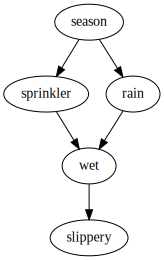

In [2]:
sprinkler = CausalGraphicalModel(
    nodes=["season", "rain", "sprinkler", "wet", "slippery"],
    edges=[
        ("season", "rain"), 
        ("season", "sprinkler"), 
        ("rain", "wet"),
        ("sprinkler", "wet"), 
        ("wet", "slippery")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
sprinkler.draw()

In [3]:
# get the distribution implied by the graph
print(sprinkler.get_distribution())

P(season)P(sprinkler|season)P(rain|season)P(wet|rain,sprinkler)P(slippery|wet)


In [4]:
# check for d-seperation of two nodes
sprinkler.is_d_separated("slippery", "season", {"wet"})

True

In [5]:
# get all the conditional independence relationships implied by a CGM
sprinkler.get_all_independence_relationships()

[('sprinkler', 'rain', {'season'}),
 ('sprinkler', 'slippery', {'wet'}),
 ('sprinkler', 'slippery', {'rain', 'wet'}),
 ('sprinkler', 'slippery', {'season', 'wet'}),
 ('sprinkler', 'slippery', {'rain', 'season', 'wet'}),
 ('rain', 'slippery', {'wet'}),
 ('rain', 'slippery', {'sprinkler', 'wet'}),
 ('rain', 'slippery', {'season', 'wet'}),
 ('rain', 'slippery', {'season', 'sprinkler', 'wet'}),
 ('wet', 'season', {'rain', 'sprinkler'}),
 ('wet', 'season', {'rain', 'slippery', 'sprinkler'}),
 ('season', 'slippery', {'wet'}),
 ('season', 'slippery', {'rain', 'wet'}),
 ('season', 'slippery', {'sprinkler', 'wet'}),
 ('season', 'slippery', {'rain', 'sprinkler'}),
 ('season', 'slippery', {'rain', 'sprinkler', 'wet'})]

In [6]:
# check backdoor adjustment set
sprinkler.is_valid_backdoor_adjustment_set("rain", "slippery", {"wet"})

False

In [7]:
# get all backdoor adjustment sets
sprinkler.get_all_backdoor_adjustment_sets("rain", "slippery")

frozenset({frozenset({'sprinkler'}),
           frozenset({'season'}),
           frozenset({'season', 'sprinkler'})})

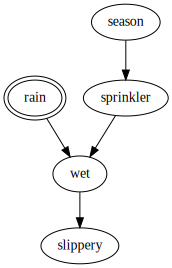

In [8]:
# get the graph created by intervening on node "rain"
do_sprinkler = sprinkler.do("rain")

do_sprinkler.draw()

# Latent Variables 

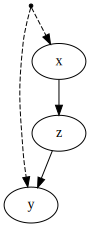

In [9]:
dag_with_latent_variables = CausalGraphicalModel(
    nodes=["x", "y", "z"],
    edges=[
        ("x", "z"),
        ("z", "y"), 
    ],
    latent_edges=[
        ("x", "y")
    ]
)

dag_with_latent_variables.draw()

In [10]:
# here there are no observed backdoor adjustment sets
dag_with_latent_variables.get_all_backdoor_adjustment_sets("x", "y")

frozenset()

In [11]:
# but there is a frontdoor adjustment set
dag_with_latent_variables.get_all_frontdoor_adjustment_sets("x", "y")

frozenset({frozenset({'z'})})

# StructuralCausalModels

For Structural Causal Models (SCM) we need to specify the functional form of each node:

In [12]:
from causalgraphicalmodels import StructuralCausalModel
import numpy as np

scm = StructuralCausalModel({
    "x1": lambda     n_samples: np.random.binomial(n=1,p=0.7,size=n_samples),
    "x2": lambda x1, n_samples: np.random.normal(loc=x1, scale=0.1),
    "x3": lambda x2, n_samples: x2 ** 2,
})

The only requirement on the functions are:
 - that variable names are consistent 
 - each function accepts keyword variables in the form of `numpy` arrays and output numpy arrays of shape [n_samples] 
 - that in addition to it's parents, each function takes a `n_samples` variables indicating how many samples to generate 
 - that any function acts on each row independently. This ensure that the output samples are independent
 
Wrapping these functions in the `StructuralCausalModel` object allows us to easily generate samples: 

In [13]:
ds = scm.sample(n_samples=100)

ds.head()

,x1,x2,x3
0,1,1.004020,1.008056
1,1,0.902045,0.813686
2,1,1.150323,1.323242
3,1,0.984634,0.969504
4,1,1.023118,1.046770


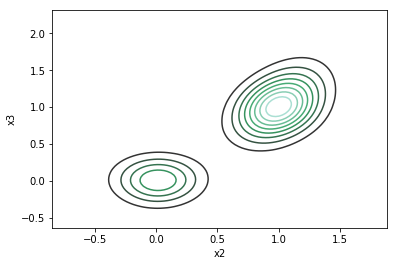

In [14]:
# and visualise the samples
import seaborn as sns

%matplotlib inline

sns.kdeplot(
    data=ds.x2,
    data2=ds.x3,
)

And to access the implied CGM"

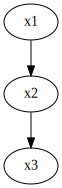

In [15]:
scm.cgm.draw()

And to apply an intervention:

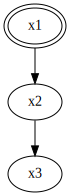

In [16]:
scm_do = scm.do("x1")

scm_do.cgm.draw()

And sample from the distribution implied by this intervention:

In [17]:
scm_do.sample(n_samples=5, set_values={"x1": np.arange(5)})

,x1,x2,x3
0,0,0.258736,0.066944
1,1,1.142529,1.305371
2,2,1.927665,3.715894
3,3,2.878977,8.288507
4,4,4.098250,16.795653
